In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier  
from sklearn.ensemble import AdaBoostClassifier 
import xgboost
    # NOTA
    # xgboost.XGBRFClassifier En cada secuencia tiene un RandomForest
    # xgboost.XGBClassifier sin RandomForest
# ------------------
# Pipeline
from sklearn.pipeline import Pipeline
    # NOTA
    # Hay que poner las etiquetas manualmente. El otro es 'from sklearn.pipeline import make_pipeline'
# ------------------
# Métricas de validación
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
# ------------------
# GridSearch
from sklearn.model_selection import GridSearchCV
# ------------------
# Balanceo
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
# ------------------
# Otras
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
# ------------------
# Pickle
import pickle



# LECTURA CSV
vinos = pd.read_csv('data/winequalityN.csv')


blanco=vinos[vinos['type']=='white'].reset_index()
blanco = blanco.drop(['index', 'type'], axis=1)


print("Columnas pre drop:", len(blanco))
blanco = blanco.dropna()
print("Columnas post drop:", len(blanco))


# Cambiamos la variable Target para que sea solo entre 'aptos=1' y 'no aptos=0'
my_dict={3:0, 4:0, 5:0,
        6:1, 7:1, 8:1, 9:1}
blanco['apto']= blanco['quality'].map(my_dict)
blanco = blanco.drop(['quality'], axis=1)


blanco.insert(5,'bound sulfur dioxide', (blanco['total sulfur dioxide']-blanco['free sulfur dioxide']))
blanco = blanco.drop(['total sulfur dioxide'], axis=1)

blanco = blanco.drop(['density'], axis=1)

from scipy.stats import iqr

def outliers_quantie(df, feature, param=1.5):  
        
    iqr_ = iqr(df[feature], nan_policy='omit')
    q1 = np.nanpercentile(df[feature], 25)
    q3 = np.nanpercentile(df[feature], 75)
    
    th1 = q1 - iqr_*param
    th2 = q3 + iqr_*param
    
    return df[(df[feature] >= th1) & (df[feature] <= th2)].reset_index(drop=True)


print("Len original:", len(blanco))
blanco = outliers_quantie(blanco, 'residual sugar')
print("Len sin outliers en residual sugar:", len(blanco))

print("Len original:", len(blanco))
blanco = outliers_quantie(blanco, 'citric acid')
print("Len sin outliers en citric acid:", len(blanco))

print("Len original:", len(blanco))
blanco = outliers_quantie(blanco, 'chlorides')
print("Len sin outliers en chlorides:", len(blanco))

print("Len original:", len(blanco))
blanco = outliers_quantie(blanco, 'bound sulfur dioxide')
print("Len sin outliers en bound sulfur dioxide:", len(blanco))

print("Len original:", len(blanco))
blanco = outliers_quantie(blanco, 'free sulfur dioxide')
print("Len sin outliers en free sulfur dioxide:", len(blanco))


X = blanco.iloc[:,:-1]
y = blanco['apto']

seed=33

ros = RandomOverSampler(random_state=seed)
X_ros, y_ros = ros.fit_resample(X, y)


X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.2, stratify=y_ros, random_state=seed)


pipe = Pipeline(steps=[('scaler', StandardScaler()),
                       ('kbest', SelectKBest()),
                       ('classifier', LogisticRegression(random_state=seed))])



Columnas pre drop: 4898
Columnas post drop: 4870
Len original: 4870
Len sin outliers en residual sugar: 4863
Len original: 4863
Len sin outliers en citric acid: 4598
Len original: 4598
Len sin outliers en chlorides: 4426
Len original: 4426
Len sin outliers en bound sulfur dioxide: 4398
Len original: 4398
Len sin outliers en free sulfur dioxide: 4343


In [2]:
# svm_params = {'kbest__k': [8,9,10],
#               'classifier': [SVC()],
#               'classifier__C': [0.5,0.8,1],
#               'classifier__kernel': ['linear','rbf','sigmoid']
# }
# Accuracy Score 0.7793505412156536 
# Best model. Best Params {'classifier': SVC(C=1), 'classifier__C': 1, 'classifier__kernel': 'rbf', 'kbest__k': 10} 


# log_params = {'kbest__k': [8,9,10],
#               'classifier': [LogisticRegression()],
#               'classifier__penalty': ['l1','l2'],
#               'classifier__C': np.logspace(0,2,5)
# }

# Best model. Best Params {'classifier': LogisticRegression(), 'classifier__C': 1.0, 'classifier__penalty': 'l2', 'kbest__k': 9} 
# Accuracy Score 0.7185678601165695 


# knn_params = {'kbest__k': [8,9,10],
#               'classifier': [KNeighborsClassifier()],
#               'classifier__n_neighbors': [5,10,12,17,20],
#               'classifier__weights': ['uniform','distance']
# }
# 'classifier__n_neighbors': 17, 'classifier__weights': 'distance', 'kbest__k': 10
# Accuracy Score 0.9075770191507078 



# rf_params = {'kbest__k': [8,9,10],
#               'classifier': [RandomForestClassifier()],
#               'classifier__n_estimators': [50,100,150],
#               'classifier__max_depth': [2,3,4,5,6,7],
#               'classifier__min_samples_leaf': [1,3,5]
# }
# 'classifier__max_depth': 7, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 150, 'kbest__k': 10
# Accuracy Score 0.829308909242298 



# gb_params = {'kbest__k': [8,9,10],
#               'classifier': [GradientBoostingClassifier()],
#             #   'classifier__max_depth': [2,3,4,5,6],
#               'classifier__max_depth': [5,6,7],
#               'classifier__n_estimators': [430,440,445,450],
#               'classifier__learning_rate': [0.1,0.15,0.2,0.25]
# }


# ada_params = {'kbest__k': [8,9,10],
#               'classifier': [AdaBoostClassifier()],
#               'classifier__n_estimators': [150,200,300,350],
#               'classifier__learning_rate': [0.3,0.5,0.7,1]
# }
# 'classifier__learning_rate': 0.7, 'classifier__n_estimators': 300, 'kbest__k': 10} 
# Accuracy Score 0.7535387177352206 


xgb_params = {'kbest__k': [8,9,10],
              'classifier': [xgboost.XGBRFClassifier()],
              'classifier__n_estimators': [175,200,225],
              'classifier__learning_rate': [0.01,0.02,0.03,0.05]
}
# Accuracy Score 0.8018318068276437 

# search_space = [svm_params, log_params, knn_params, rf_params, gb_params, ada_params, xgb_params]
search_space = [xgb_params]

clf = GridSearchCV(estimator=pipe, param_grid=search_space, cv=3, n_jobs=-1)

In [3]:
best_model = clf.fit(X_train, y_train)

Best model. Best Score 0.7734749115136372 
 --------------------------------------------------
Best model. Best Params {'classifier': XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, gamma=None, gpu_id=None, grow_policy=None,
                importance_type=None, interaction_constraints=None,
                learning_rate=0.01, max_bin=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=200, n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=None,
                reg_alpha=None, sampling_method=None, ...), 'classifier__learning_rate': 0.01, 'classifier__n_estimators': 200, 'kbest__k': 10} 
 -----

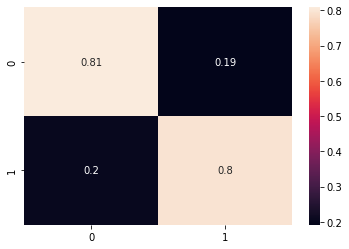

In [4]:
y_pred = best_model.best_estimator_.predict(X_test)
print('Best model. Best Score', best_model.best_score_, '\n','-'*50)
print('Best model. Best Params', best_model.best_params_, '\n','-'*50)
print('Accuracy Score', accuracy_score(y_test, y_pred), '\n','-'*50)
print('Confusion Matrix \n', confusion_matrix(y_test,y_pred), '\n','-'*50)
sns.heatmap(confusion_matrix(y_test,y_pred, normalize='true'), annot=True);

In [5]:
# with open('model_xgb.model', "wb") as archivo_salida:
#     pickle.dump(best_model.best_estimator_, archivo_salida)

In [6]:
# Cargar Modelo
# with open('model_xgb.model', "rb") as archivo_entrada:
#     my_model = pickle.load(archivo_entrada)    
# print(my_model)

Pipeline(steps=[('scaler', StandardScaler()), ('kbest', SelectKBest()),
                ('classifier',
                 XGBRFClassifier(base_score=0.5, booster='gbtree',
                                 callbacks=None, colsample_bylevel=1,
                                 colsample_bytree=1, early_stopping_rounds=None,
                                 enable_categorical=False, eval_metric=None,
                                 gamma=0, gpu_id=-1, grow_policy='depthwise',
                                 importance_type=None,
                                 interaction_constraints='', learning_rate=0.01,
                                 max_bin=256, max_cat_to_onehot=4,
                                 max_delta_step=0, max_depth=6, max_leaves=0,
                                 min_child_weight=1, missing=nan,
                                 monotone_constraints='()', n_estimators=200,
                                 n_jobs=0, num_parallel_tree=200,
                                 